In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import pandas as pd

#### Importing data set and putting into a matrix

In [2]:
# Import data. Data is in ml-latest-small/ratings.csv. 
# It has columns: userId, movieId, rating, and timestamp.

ratings = np.genfromtxt('ml-latest-small/ratings.csv', delimiter=',')
ratings = np.delete(ratings, (0), axis=0) # Remove column title row
ratings = np.delete(ratings, (3), axis=1) # Remove time stamp column

num_users = np.size(np.unique(ratings[:,0]))
num_movies = np.size(np.unique(ratings[:,1]))
num_ratings = np.shape(ratings)[0]

In [3]:
# Create a dictionary where the key is the movie id and the value is the location in data

movie_ids = {}
counter = 0
for rating in ratings:
    if rating[1] not in movie_ids.keys():
        movie_ids[rating[1]] = counter
        counter += 1

In [4]:
# Put ratings into a matrix of size num_users x num_movies. 
# To get the rating of a user for a specific movie, do data[userId - 1, movie_ids[movieId]]

data = np.zeros([num_users, num_movies])

for rating in ratings:
    user = int(rating[0]) - 1
    movie = int(movie_ids[rating[1]])
    data[user, movie] = rating[2]

##### ~ Global functions ~

In [98]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

def custom_crossval(X_train, y_train, model, num_folds=10, metrics=['RMSE', 'MAE', 'accuracy'],
                    randomize=True, include_inds=False):
    '''
    Requires a model that has the following functions:
        model.train(X, y): trains the model on a particular set of input/output
        model.predict(X): predicts y given an input of X
    '''
    X_train_folds = []
    y_train_folds =  []
    X_val_folds = []
    y_val_folds = []
    
    # necessary for some models (Naive)
    train_inds = []
    val_inds = []
    
    # initialize cumulative errors object
    cumulative_metrics = {}
    for met in metrics:
        cumulative_metrics[met] = 0
    
    k = num_folds
    
    ##############################################################################
    # 1. Divide dataset into training and validation folds
    idx = np.arange(X_train.shape[0])
    fold_size = X_train.shape[0] // num_folds
    
    # randomize indices
    if randomize:
        np.random.shuffle(idx)

    for i in range(num_folds):
        test_idx = idx[i*fold_size:(i+1)*fold_size]
        train_idx = np.concatenate((idx[:i*fold_size:], idx[(i+1)*fold_size:]))

        X_train_folds.append(X_train[train_idx])
        y_train_folds.append(y_train[train_idx])

        X_val_folds.append(X_train[test_idx])
        y_val_folds.append(y_train[test_idx])
        
        train_inds.append(train_idx)
        val_inds.append(test_idx)
        
    ##############################################################################
    # 2. Train on train set, test on validation set, calculate errors
    for i in range(len(X_train_folds)):
        # train model on the train folds (k-1 folds):
        model.train(X_train_folds[i], y_train_folds[i])

        # measure error of test predictions
        if include_inds:
            y_pred = model.predict(X_val_folds[i], inds=val_inds[i])
        else:
            y_pred = model.predict(X_val_folds[i])
        
        # calculate errors:
        y_actual = y_val_folds[i]
        for met in metrics:
            if met == 'RMSE':
                rms = sqrt(mean_squared_error(y_actual, y_pred))
                cumulative_metrics[met] += rms
            elif met == 'MAE':
                mae = mean_absolute_error(y_actual, y_pred)
                cumulative_metrics[met] += mae
            elif met == 'accuracy':
                num_correct = np.sum(y_pred == y_actual)
                cumulative_metrics[met] += num_correct / y_val_folds[i].shape[0]
            else:
                raise Exception("Error: requested error ('{}') is not incoporated into this function yet.".format(met))
    
    ##############################################################################
    # 3. Average and return metrics object
    for met in metrics:
        cumulative_metrics[met] = cumulative_metrics[met] / len(X_train_folds)
    return cumulative_metrics

#### Trimming the data set

In [5]:
# Popular movie trimming

nz_movie = np.count_nonzero(data, axis=0)
unpop_movies = []
for i in range(len(nz_movie)):
    if nz_movie[i] <= 2:
        unpop_movies.append(i)

data_popular = np.delete(data, unpop_movies, axis=1)
# print(np.unique(np.count_nonzero(data_popular, axis=0)))

In [6]:
# Unpopular movie trimming

nz_movie = np.count_nonzero(data, axis=0)
pop_movies = []
for i in range(len(nz_movie)):
    if nz_movie[i] > 2:
        pop_movies.append(i)
        
data_unpopular = np.delete(data, pop_movies, axis=1)
# print(np.unique(np.count_nonzero(data_unpopular, axis=0)))

In [7]:
# High variance movie trimming

nz_movie = np.count_nonzero(data, axis=0)
movies_less5 = []
for i in range(len(nz_movie)):
    if nz_movie[i] < 5:
        movies_less5.append(i)

data_more5 = np.delete(data, movies_less5, axis=1)

variances = np.zeros(np.shape(data_more5)[1])
for i in range(np.shape(data_more5)[1]):
    variances[i] = np.var(data_more5[:, i])

lowvar_movies = []
for i in range(np.shape(data_more5)[1]):
    if variances[i] < 2:
        lowvar_movies.append(i)
data_highvar = np.delete(data_more5, lowvar_movies, axis=1)

# print(data_highvar.shape)
# print(np.var(data_highvar[:,13]))

#### Question 1

In [8]:
num_available_ratings = np.count_nonzero(data)
num_possible_ratings = np.size(data)

sparsity = num_available_ratings / num_possible_ratings
print('Sparsity =', sparsity)

Sparsity = 0.016999683055613623


#### Question 2

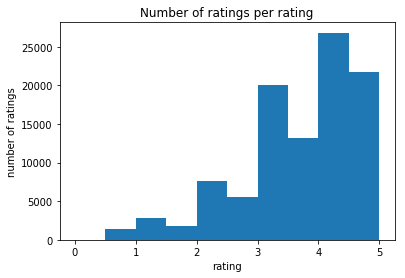

In [9]:
# Put all nonzero ratings into an array, nonzero_ratings, and make a histogram.

nz = np.nonzero(data)

nonzero_ratings = np.zeros(len(nz[0]))
for i in range(len(nz[0])):
    nonzero_ratings[i] = data[nz[0][i], nz[1][i]]

plt.figure()
plt.hist(nonzero_ratings, np.arange(11)/2)
plt.title('Number of ratings per rating')
plt.xlabel('rating')
plt.ylabel('number of ratings')
plt.show()

#### Question 3

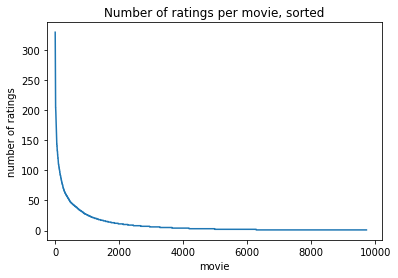

In [10]:
# Plot the number of nonzero ratings for each movie.
# NOTE: the x axis does NOT correspond to the movieId or movie index in data.

nz_movie = np.count_nonzero(data, axis=0)
sorted_nz_movie = np.sort(nz_movie)[::-1]

plt.figure()
plt.plot(sorted_nz_movie)
plt.title('Number of ratings per movie, sorted')
plt.xlabel('movie')
plt.ylabel('number of ratings')
plt.xlim(left=-250)
plt.show()

#### Question 4

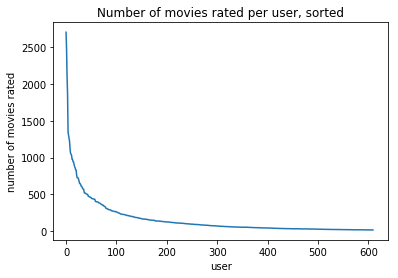

In [11]:
# Plot the number of ratings each user gave.
# NOTE: the x axis does NOT correspond to the userID.

nz_user = np.count_nonzero(data, axis=1)
sorted_nz_user = np.sort(nz_user)[::-1]

plt.figure()
plt.plot(sorted_nz_user)
plt.title('Number of movies rated per user, sorted')
plt.xlabel('user')
plt.ylabel('number of movies rated')
plt.xlim(left=-25)
plt.show()

#### Question 6

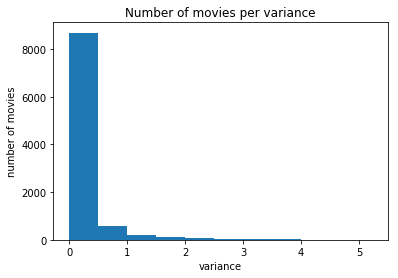

In [12]:
# Histogram for number of movies whose variance in scores falls in some range.

variances = np.zeros(num_movies)
for i in range(num_movies):
    variances[i] = np.var(data[:, i])

plt.figure()
plt.hist(variances, np.arange(12)/2)
plt.xlim(right=5.5)
plt.title('Number of movies per variance')
plt.xlabel('variance')
plt.ylabel('number of movies')
plt.show()

#### Question 30

Calculate the average rating, $\mu_i$, for each user rating, $r_i$

##### Define Naive model

In [95]:
class Naive():
    
    # mean ratings, one required per user
    mu_i = None
    
    def __init__(self, X_train):
        self.mu_i = np.zeros(X_train.shape)
        self.train(X_train, None, enabled=True)
        
    # calculate mu_i for training
    def train(self, X, y, enabled=False):
        if enabled:
            self.mu_i = np.mean(X, axis=1)
        
    # return mu_i as rating prediction (for each movie)
    def predict(self, X, inds=None):
        if inds is None:
            return np.repeat(np.reshape(self.mu_i, (self.mu_i.shape[0], 1)), X.shape[1], axis=1)
        else:
            # return a specific set of mu_i's:
            return np.repeat(np.reshape(self.mu_i[inds], (self.mu_i[inds].shape[0], 1)), X.shape[1], axis=1)

In [96]:
model = Naive(data)
mu_i = model.mu_i
print("average rating shape:", mu_i.shape, "- should be", num_users)
print("average rating range:", np.min(mu_i), np.max(mu_i))

print("\nshould match manual calculation:")
mu_i = np.mean(data, axis=1)
print("average rating shape:", mu_i.shape, "- should be", num_users)
print("average rating range:", np.min(mu_i), np.max(mu_i))

y_pred = model.predict(data)
print(data.shape, y_pred.shape)

average rating shape: (610,) - should be 610
average rating range: 0.0026223776223776225 0.941125051419169

should match manual calculation:
average rating shape: (610,) - should be 610
average rating range: 0.0026223776223776225 0.941125051419169
(610, 9724) (610, 9724)


In [99]:
error = custom_crossval(data, data, model, num_folds=10, metrics=['RMSE', 'accuracy'],
                        randomize=False, include_inds=True)

print('Average RMSE:', error['RMSE'])

Average RMSE: 0.46125510728767294
